# Creación de neurona con dos nodos
artificial para ETH


In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


## Descargar datos de Ethereum

In [9]:
eth = yf.download('ETH-USD', start='2020-01-01', end='2025-10-20')
data = np.log(eth[['Close']].values)  # Usamos log para estabilizar variaciones

# Normalizar entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

C:\Users\raton\AppData\Local\Temp\ipykernel_17880\609896406.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eth = yf.download('ETH-USD', start='2020-01-01', end='2025-10-20')
[*********************100%***********************]  1 of 1 completed


## Preprocesamiento de datos

In [10]:
# Crear secuencias para entrenamiento
def create_sequences(data, sequence_length=4):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 4
X, y = create_sequences(data_scaled, sequence_length)

# Dividir entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"Datos de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Datos de prueba: {X_test.shape}, {y_test.shape}")

Datos de entrenamiento: (1903, 4), (1903, 1)
Datos de prueba: (212, 4), (212, 1)


## Definir la estructura de una sola neurona

In [11]:
class SingleNeuronWithTwoHiddenNodes:
    def __init__(self, input_dim):
        # Capa oculta con 2 nodos
        self.W1 = tf.Variable(tf.random.normal([input_dim, 2], stddev=0.1), name='W1')
        self.b1 = tf.Variable(tf.zeros([2]), name='b1')

        # Capa de salida (1 nodo)
        self.W2 = tf.Variable(tf.random.normal([2, 1], stddev=0.1), name='W2')
        self.b2 = tf.Variable(tf.zeros([1]), name='b2')

    def __call__(self, x):
        hidden = tf.nn.relu(tf.matmul(x, self.W1) + self.b1)
        output = tf.matmul(hidden, self.W2) + self.b2  # Salida escalar
        return output

    def get_weights(self):
        return {
            "W1": self.W1.numpy(),
            "b1": self.b1.numpy(),
            "W2": self.W2.numpy(),
            "b2": self.b2.numpy()
        }

# Crear la neurona
neurona = SingleNeuronWithTwoHiddenNodes(input_dim=sequence_length)
print("\n✅ Neurona creada exitosamente!")


✅ Neurona creada exitosamente!


## Función de pérdida y optimizador

In [12]:
# Mostrar pesos iniciales
pesos = neurona.get_weights()
print(f"W1:\n{pesos['W1']}")
print(f"b1:\n{pesos['b1']}")
print(f"W2:\n{pesos['W2']}")
print(f"b2:\n{pesos['b2']}")

def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))  # MSE

optimizer = tf.optimizers.Adam(learning_rate=0.01)

W1:
[[0.17593953 0.03742531]
 [0.10868633 0.21643789]
 [0.09127206 0.06396431]
 [0.01210219 0.06147981]]
b1:
[0. 0.]
W2:
[[ 0.14020114]
 [-0.01655499]]
b2:
[0.]


## Entrenamiento de la neurona

In [13]:
epochs = 200

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        y_pred = neurona(X_train.astype(np.float32))
        loss = loss_fn(y_train.astype(np.float32), y_pred)

    # Calcular gradientes y actualizar pesos
    gradients = tape.gradient(loss, [neurona.W1, neurona.b1, neurona.W2, neurona.b2])
    optimizer.apply_gradients(zip(gradients, [neurona.W1, neurona.b1, neurona.W2, neurona.b2]))

    if epoch % 20 == 0:
        print(f"Época {epoch:03d} | Pérdida: {loss.numpy():.6f}")

y_pred_test = neurona(X_test.astype(np.float32))
y_pred_test_actual = scaler.inverse_transform(y_pred_test.numpy())
y_test_actual = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_actual, y_pred_test_actual)
mse = mean_squared_error(y_test_actual, y_pred_test_actual)
rmse = np.sqrt(mse)

print("\n=== MÉTRICAS DE EVALUACIÓN ===")
print(f"MAE : {mae:.4f}")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


Época 000 | Pérdida: 0.489132
Época 020 | Pérdida: 0.013384
Época 040 | Pérdida: 0.009082
Época 060 | Pérdida: 0.007662
Época 080 | Pérdida: 0.006005
Época 100 | Pérdida: 0.004356
Época 120 | Pérdida: 0.003004
Época 140 | Pérdida: 0.001999
Época 160 | Pérdida: 0.001300
Época 180 | Pérdida: 0.000851

=== MÉTRICAS DE EVALUACIÓN ===
MAE : 0.0522
MSE : 0.0047
RMSE: 0.0685


## Visualización del entrenamiento

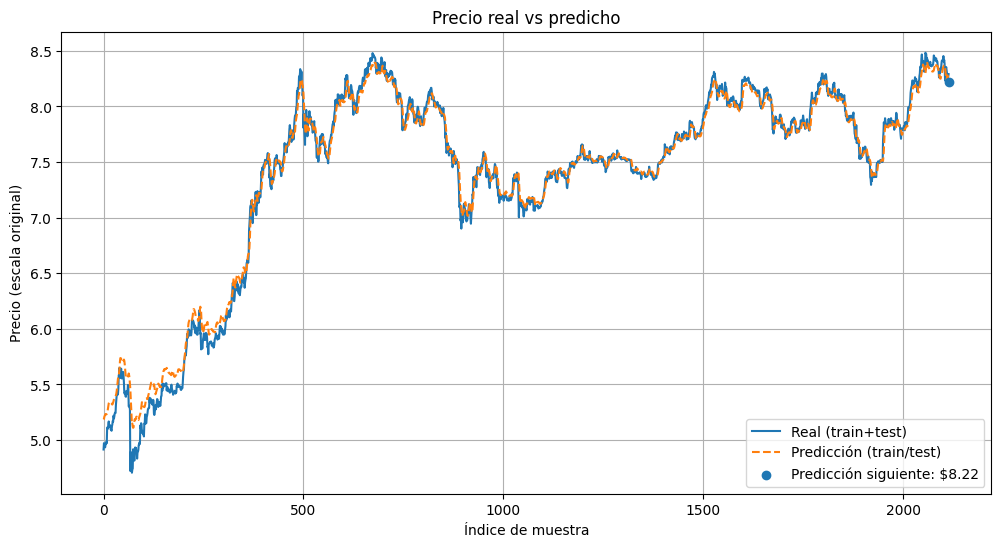

In [14]:
# ---------------------------
# GRÁFICA: real vs predicho
# ---------------------------

# Predicciones sobre todo el conjunto (train + test) para visualización
y_pred_train = neurona(X_train.astype(np.float32)).numpy()  # (n_train, 1)
y_pred_test  = neurona(X_test.astype(np.float32)).numpy()   # (n_test, 1)

# Invertir la normalización a la escala original
y_train_actual = scaler.inverse_transform(y_train)          # (n_train, 1)
y_test_actual  = scaler.inverse_transform(y_test)          # (n_test, 1)
y_pred_train_actual = scaler.inverse_transform(y_pred_train)
y_pred_test_actual  = scaler.inverse_transform(y_pred_test)

# Construir un arreglo completo de la serie temporal para comparar:
# colocamos NaN donde no haya predicción para que la gráfica sea clara
total_len = len(X_train) + len(X_test)
series_indexes = np.arange(total_len)

# Para visualizar en la misma línea temporal:
preds_full = np.full((total_len, 1), np.nan, dtype=np.float32)
# llenar la parte de train y test en sus posiciones relativas
preds_full[:len(y_pred_train_actual), 0] = y_pred_train_actual.flatten()
preds_full[len(y_pred_train_actual):len(y_pred_train_actual)+len(y_pred_test_actual), 0] = y_pred_test_actual.flatten()

# Serie real completa (recortada para las mismas posiciones: usamos y_train + y_test)
real_full = np.vstack([y_train_actual, y_test_actual])

# Predicción del siguiente paso (últimos datos)
ultimos_datos = data_scaled[-sequence_length:].flatten().reshape(1, -1)
prediccion_normalizada = neurona(ultimos_datos.astype(np.float32))
prediccion = scaler.inverse_transform(prediccion_normalizada.numpy())  # (1,1)

# Índice para la predicción futura (colocarlo justo después del último punto real)
future_index = total_len  # dibujaremos un punto extra

# Dibujar
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(series_indexes, real_full.flatten(), label="Real (train+test)")
plt.plot(series_indexes, preds_full.flatten(), label="Predicción (train/test)", linestyle='--')
plt.scatter([future_index], [prediccion[0,0]], label=f"Predicción siguiente: ${prediccion[0,0]:.2f}", zorder=5)
plt.xlabel("Índice de muestra")
plt.ylabel("Precio (escala original)")
plt.title("Precio real vs predicho")
plt.legend()
plt.grid(True)
plt.show()


# Predicciones

In [15]:
ultimos_datos = data_scaled[-sequence_length:].flatten().reshape(1, -1)
prediccion_normalizada = neurona(ultimos_datos.astype(np.float32))
prediccion = np.exp(scaler.inverse_transform(prediccion_normalizada.numpy()))

print("\n=== PREDICCIÓN DE LA NEURONA ===")
print(f"Predicción del siguiente precio: ${prediccion[0][0]:.2f}")


=== PREDICCIÓN DE LA NEURONA ===
Último precio real: $8.29
Predicción del siguiente precio: $3722.43


## Pesos finales

In [16]:
# Mostrar pesos finales
pesos = neurona.get_weights()
print("\n=== PESOS FINALES ===")
print("W1:", pesos["W1"])
print("b1:", pesos["b1"])
print("W2:", pesos["W2"])
print("b2:", pesos["b2"])


=== PESOS FINALES ===
W1: [[0.462731   0.24695511]
 [0.395751   0.4263679 ]
 [0.3791573  0.27527678]
 [0.3011646  0.2748536 ]]
b1: [ 0.00383424 -0.17854239]
W2: [[0.4006305 ]
 [0.25764748]]
b2: [0.09692922]
